<a href="https://colab.research.google.com/github/junfrankohara/git-practice/blob/main/goblet_cell_detection_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Python 3.8 (optional, only if needed for compatibility)
!sudo apt install python3.8

# Uninstall preinstalled incompatible versions of torch and torchvision
!pip uninstall -y torch torchvision

# Install specific versions of torch and torchvision compatible with CUDA 11.8
!pip install torch==2.1.0 torchvision==0.16.0 --index-url https://download.pytorch.org/whl/cu118

# Install compatible versions of numpy, segmentation_models_pytorch, and albumentations
!pip install numpy==1.24.3 segmentation-models-pytorch==0.2.1 albumentations==1.3.1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.8 is already the newest version (3.8.20-1+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Found existing installation: torch 2.1.0+cu118
Uninstalling torch-2.1.0+cu118:
  Successfully uninstalled torch-2.1.0+cu118
Found existing installation: torchvision 0.16.0+cu118
Uninstalling torchvision-0.16.0+cu118:
  Successfully uninstalled torchvision-0.16.0+cu118
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.1.0%2Bcu118-cp311-cp311-linux_x86_64.whl (2325.9 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.16.0%2Bcu118-cp311-cp311-linux_x86_64.whl (6.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.6.0+cu124 requires torch==2.6.

In [2]:
# Import necessary libraries for image processing, visualization, and deep learning
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize
from tqdm import tqdm
import torch
import torchvision
import segmentation_models_pytorch as smp
import urllib.request

# Set default figure size for matplotlib plots
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Set device to GPU if available
DEVICE = 'cuda'

In [3]:
# Download models and sample image
%cd /content/
%mkdir demo
print("Downloading sample image...")
sample_url = "https://raw.githubusercontent.com/junfrankohara/goblet_cell_detection/af5d58b38eb450ac5058978aad034e40cda84b93/sample.png"
urllib.request.urlretrieve(sample_url, '/content/demo/sample.png')
print("Downloading segmentation models...")
model1_url = "https://github.com/junfrankohara/goblet_cell_detection/releases/download/new_segmentation/epi_seg.pth"
urllib.request.urlretrieve(model1_url, '/content/demo/model1.pth')
model2_url = "https://github.com/junfrankohara/goblet_cell_detection/releases/download/new_segmentation/goblet_seg.pth"
urllib.request.urlretrieve(model2_url, '/content/demo/model2.pth')

%ls /content/demo/

/content
mkdir: cannot create directory ‘demo’: File exists
model1.pth  model2.pth  sample.png


In [4]:
# Create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name = 'efficientnet-b4',
    encoder_weights = 'imagenet',
    classes = 1,
    activation = 'sigmoid',
)

#　Load model1 and model2
preprocessing_fn = smp.encoders.get_preprocessing_fn('efficientnet-b4', 'imagenet')
# Use map_location to load models to the specified device
model1 = torch.load('/content/demo/model1.pth')
model2 = torch.load('/content/demo/model2.pth')


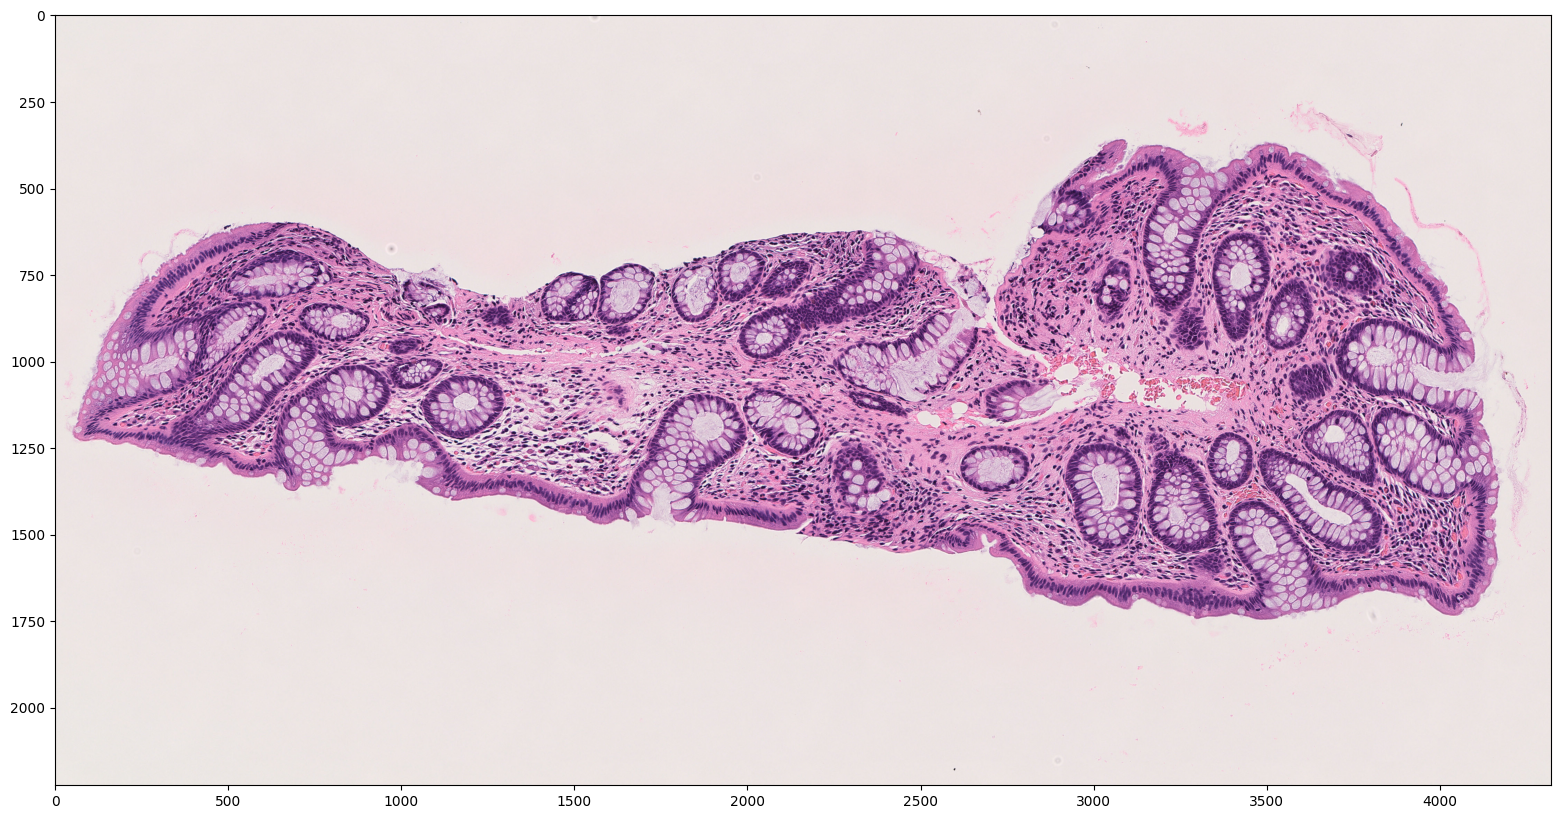

In [5]:
#Load image
img_path = '/content/demo/sample.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

100%|██████████| 72/72 [00:02<00:00, 28.27it/s]


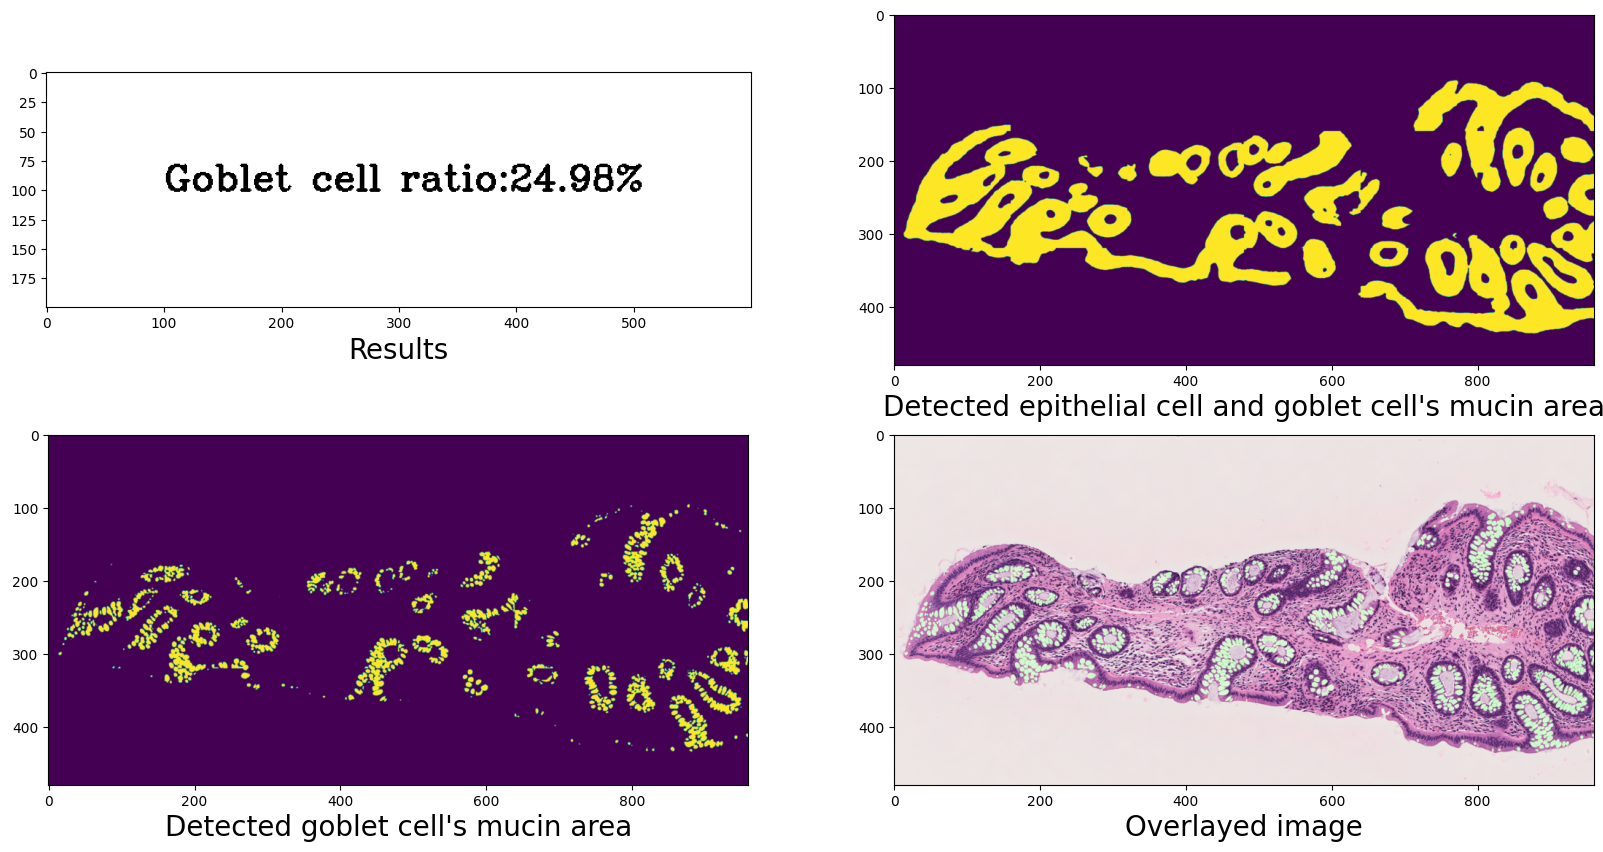

In [6]:

def crop_to_640pix(img):
    """Crops image to size of 640x640pix images."""
    crop_array=img.reshape(int(img.shape[0]/640),640,int((img.shape[1])/640),640, 3)
    crop_array=crop_array.transpose([0,2,1,3,4])
    crop_array=crop_array.reshape(-1,640,640,3)
    return crop_array

def assemble_with640pix(crop_arrays, img_height, img_width):
    """Assembles size of 640x640pix predicted images into a large image that indicates epithelial cells and goblet cell mucin's area."""
    re_x=crop_arrays.reshape(int(img_height/640),int(img_width/640),640,640)
    re_x=re_x.transpose([0,2,1,3])
    return re_x.reshape(img_height, img_width).astype("uint8")

def crop_to_320pix(img):
    """Crops image to size of 320x320pix images."""
    crop_array=img.reshape(int(img.shape[0]/320),320,int((img.shape[1])/320),320, 3)
    crop_array=crop_array.transpose([0,2,1,3,4])
    crop_array=crop_array.reshape(-1,320,320,3)
    return crop_array

def assemble_with320pix(crop_arrays, img_height, img_width):
    """Assembles size of 320x320pix predicted images into a large image that indicates goblet cell mucin's area."""
    re_x=crop_arrays.reshape(int(img_height/320),int(img_width/320),320,320)
    re_x=re_x.transpose([0,2,1,3])
    return re_x.reshape(img_height, img_width).astype("uint8")


#Makes image shape divisible by 640pix.
img = img[:int(img.shape[0]/640)*640, :int(img.shape[1]/640)*640,:]
img_height = img.shape[0]
img_width=  img.shape[1]
#Crops image to size of 640x640pix images.
crop_array = crop_to_640pix(img)
epithelium_list=[]

#Adopt cropped images to model1 for predicting epithelial cell and goblet cell's mucin area.
for rgb in tqdm(crop_array):
    half_rgb = resize(rgb, (320, 320), anti_aliasing=True)
    image = preprocessing_fn(half_rgb)
    image = image.transpose(2, 0, 1).astype('float32')
    image = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    predict = model1(image)
    predict = predict.detach().cpu().numpy()[0]
    pr_epithelium = predict[0,:,:]
    pr_epithelium = resize(pr_epithelium, (640, 640), anti_aliasing=True)
    pr_epithelium = np.where(pr_epithelium>0.7, 1, 0)
    pr_epithelium = pr_epithelium.astype("uint8")

    epithelium_list.append(pr_epithelium)
epithelium_arrays = np.stack(epithelium_list)
#Assemble size of 640x640pix predicted images into a large image that indicates epithelial cells and goblet cell's mucin area.
detect_epithelium = assemble_with640pix(epithelium_arrays, img_height, img_width)

detect_epithelium3 = np.stack([detect_epithelium,detect_epithelium,detect_epithelium], axis=-1).astype("uint8")
#Generate predicted epithelial cells and goblet cell's mucin images.
epithelium_img = img*detect_epithelium3
#Crop predicted image to size of 320x320pix images.
epithelium_crops = crop_to_320pix(epithelium_img)
goblet_list = []
#Adopt cropped images to model2 for predicting goblet cell's mucin area.
for crop in tqdm(epithelium_crops):
    image = preprocessing_fn(crop)
    image = image.transpose(2, 0, 1).astype('float32')
    image = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    predict = model2(image)
    predict = predict.detach().cpu().numpy()[0]
    pr_goblet = predict[0,:,:]
    pr_goblet = np.where(pr_goblet>0.7, 1, 0)
    goblet_list.append(pr_goblet)
goblet_arrays = np.stack(goblet_list)
#Assemble size of 320x320pix predicted images into a large image that indicates goblet cell's mucin area.
detect_goblet = assemble_with320pix(goblet_arrays, img_height, img_width)
#Calculate the area of epithelial cells and goblet cell's mucin.
epithelium_bins = np.bincount(detect_epithelium.astype("uint8").flatten())[1]
#Calculate the area of goblet cell's mucin.
goblet_bins = np.bincount(detect_goblet.astype("uint8").flatten())[1]
#Generate overlayed image
goblet_arrays_255 = detect_goblet.astype("uint8")*255
mask_color = np.stack([np.zeros(detect_goblet.shape), goblet_arrays_255, np.zeros(detect_goblet.shape)], axis=-1)
goblet_filt = np.where(mask_color>0, True, False)
overlay = np.where(goblet_filt, (0.9*mask_color+0.1*img).astype(np.uint8), img)
overlay = resize(overlay, (overlay.shape[0] / 4, overlay.shape[1] / 4), anti_aliasing=True)
#Calculate "goblet cell ratio".
results = np.ones((200,600,3))
results = cv2.putText(results,text='Goblet cell ratio:{}%'.format(round(goblet_bins/epithelium_bins*100,2)),org=(100, 100),fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1.0, color=(0, 0, 0),thickness=2,lineType=cv2.LINE_4)
#Display generated images
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0, 0].imshow(results)
axes[0, 0].set_xlabel('Results', fontsize=20)
axes[0, 1].imshow(resize(detect_epithelium, (detect_epithelium.shape[0] / 4, detect_epithelium.shape[1] / 4), anti_aliasing=True))
axes[0, 1].set_xlabel("Detected epithelial cell and goblet cell's mucin area", fontsize=20)
axes[1, 0].imshow(resize(detect_goblet, (detect_goblet.shape[0] / 4, detect_goblet.shape[1] / 4), anti_aliasing=True))
axes[1, 0].set_xlabel("Detected goblet cell's mucin area", fontsize=20)
axes[1, 1].set_xlabel("Overlayed image", fontsize=20)
axes[1, 1].imshow(overlay)